In [1]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dropout, Dense, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import tensorflow.keras.utils as ku
import numpy as np

In [3]:
tokenizer = Tokenizer()

!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt \
    -O /tmp/sonnets.txt

data = open('/tmp/sonnets.txt').read()

corpus = data.lower().split('\n')

tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

input_sequence = []

for line in corpus:
  token_list = tokenizer.texts_to_sequences([line])[0]
  for i in range(1, len(token_list)):
    n_gram_sequence = token_list[:i+1]
    input_sequence.append(n_gram_sequence)

max_sequence_len = max([len(x) for x in input_sequence])
input_sequence = np.array(pad_sequences(input_sequence, maxlen=max_sequence_len, padding='pre'))

predictors, label = input_sequence[:,:-1], input_sequence[:,-1]

label = ku.to_categorical(label, num_classes=total_words)

--2021-04-20 11:04:40--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.101.128, 216.58.192.112, 74.125.137.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.101.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 93578 (91K) [text/plain]
Saving to: ‘/tmp/sonnets.txt’

/tmp/sonnets.txt    100%[===================>]  91.38K  --.-KB/s    in 0.001s  

2021-04-20 11:04:40 (124 MB/s) - ‘/tmp/sonnets.txt’ saved [93578/93578]



In [4]:
model = Sequential()
model.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(150, return_sequences=True)))
model.add(Dropout(0.2))
model.add(LSTM(100))
model.add(Dense(total_words/2, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(total_words, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 10, 100)           321100    
_________________________________________________________________
bidirectional (Bidirectional (None, 10, 300)           301200    
_________________________________________________________________
dropout (Dropout)            (None, 10, 300)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense (Dense)                (None, 1605)              162105    
_________________________________________________________________
dense_1 (Dense)              (None, 3211)              5156866   
Total params: 6,101,671
Trainable params: 6,101,671
Non-trainable params: 0
______________________________________________

In [5]:
history = model.fit(predictors, label, epochs=100, verbose=1)

Epoch 1/100
484/484 [==============================] - 53s 100ms/step - loss: 7.3268 - accuracy: 0.0195
Epoch 2/100
484/484 [==============================] - 49s 101ms/step - loss: 6.4815 - accuracy: 0.0223
Epoch 3/100
484/484 [==============================] - 48s 99ms/step - loss: 6.4055 - accuracy: 0.0230
Epoch 4/100
484/484 [==============================] - 48s 99ms/step - loss: 6.2715 - accuracy: 0.0297
Epoch 5/100
484/484 [==============================] - 48s 100ms/step - loss: 6.1678 - accuracy: 0.0382
Epoch 6/100
484/484 [==============================] - 48s 100ms/step - loss: 6.0795 - accuracy: 0.0421
Epoch 7/100
484/484 [==============================] - 48s 100ms/step - loss: 5.9854 - accuracy: 0.0437
Epoch 8/100
484/484 [==============================] - 48s 100ms/step - loss: 5.8790 - accuracy: 0.0479
Epoch 9/100
484/484 [==============================] - 48s 100ms/step - loss: 5.7892 - accuracy: 0.0539
Epoch 10/100
484/484 [==============================] - 48s 100ms/

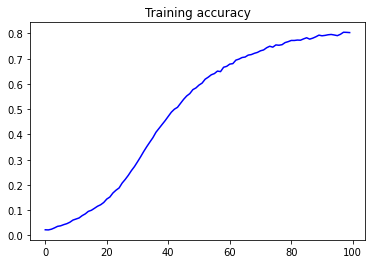

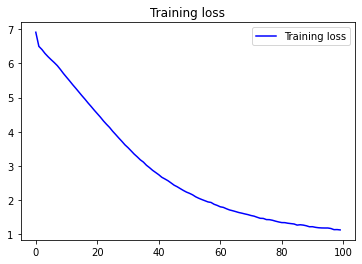

In [6]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuray')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [9]:
seed_text = "Help me Obi Wan Kenobi, you're my only hope"
next_word = 100

for i in range(next_word):
  token_list = tokenizer.texts_to_sequences([seed_text])[0]
  token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')

  predictor = model.predict_classes(token_list, verbose=0)

  output_word = ""
  for word, index in tokenizer.word_index.items():
    if index == predictor:
      output_word = word
      break
  seed_text += " " + output_word
  
print(seed_text)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Help me Obi Wan Kenobi, you're my only hope his prize for me ground ' you lies shown tender'd bevel light wrong rhyme twain staineth bevel days days last so mind days seen seen seen outworn store speaking flowers tongue controlling living older friend tongue tongue tongue much near mine eye can you prove thee well is such great same growth on men ill new new new green ill ill still of time i know thee true think true true treasure view view view cross give view view view view view view view brought back last swearing swearing groan ' in thee doth brief skill deem'd free told thine


In [10]:
model.save('shakspeare.h5')